In [1]:
import math
import torch
import time
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from local_logger import Logger
from torch.nn import Parameter
from torchvision import datasets, transforms

In [2]:
class LinearSVDO(nn.Module):
    def __init__(self, in_features, out_features, threshold, bias=True):
        super(LinearSVDO, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.threshold = threshold

        self.W = Parameter(torch.Tensor(out_features, in_features))
        self.log_sigma = Parameter(torch.Tensor(out_features, in_features))
        self.bias = Parameter(torch.Tensor(1, out_features))
        self.bias_log_sigma = Parameter(torch.Tensor(1, out_features))
        self.reset_parameters()

    def reset_parameters(self):
        self.bias.data.zero_()
        self.W.data.normal_(0, 0.01)
        self.log_sigma.data.fill_(-6)
        self.bias_log_sigma.data.fill_(-6)
        
    def forward(self, x):
        self.log_alpha = self.log_sigma * 2.0 - 2.0 * torch.log(1e-16 + torch.abs(self.W))
        self.log_alpha = torch.clamp(self.log_alpha, -10, 10) 
        
        if self.training:
            lrt_mean =  F.linear(x, self.W) + self.bias
            lrt_std = torch.sqrt(F.linear(x * x, torch.exp(self.log_sigma * 2.0)) + \
                                 torch.exp(self.bias_log_sigma * 2.0) + 1e-8)
            eps = lrt_std.data.new(lrt_std.size()).normal_()
            return lrt_mean + lrt_std * eps
    
        return F.linear(x, self.W * (self.log_alpha < 3).float()) + self.bias
    
    def prune(self, cut_off, baseline):
        if baseline:
            mask = torch.gt(torch.abs(self.W.data), cut_off)
        else:
            snr = torch.div(torch.abs(self.W.data), torch.sqrt(torch.exp(self.log_sigma.data * 2.0) + 1e-8))
            mask = torch.gt(snr, cut_off)
        self.W.data = torch.mul(mask, self.W.data)
        self.log_sigma.data = torch.mul(mask, self.log_sigma.data)
    
    def reset_weights(self, w, log_sigma, zeros=False, weights_only=False):
        if zeros:
            self.W.data = torch.zeros_like(w)
        else:
            self.W.data = w.clone()
        if not weights_only:
            self.log_sigma.data = log_sigma.clone()
    
    def get_weights(self):
        return self.W.clone()
        
    def kl_reg(self):
        # Return KL here -- a scalar 
        k1, k2, k3 = torch.Tensor([0.63576]).cuda(), torch.Tensor([1.8732]).cuda(), torch.Tensor([1.48695]).cuda()
        kl = k1 * torch.sigmoid(k2 + k3 * self.log_alpha) - 0.5 * torch.log1p(torch.exp(-self.log_alpha))
        a = - torch.sum(kl)
        return a

In [3]:
class NormalNet(nn.Module):
    def __init__(self):
        super(NormalNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,  200)
        self.fc3 = nn.Linear(200,  10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

# Define a simple 2 layer Network
class Net(nn.Module):
    def __init__(self, threshold):
        super(Net, self).__init__()
        self.fc1 = LinearSVDO(28*28, 200, threshold)
        self.fc2 = LinearSVDO(200,  200, threshold)
        self.fc3 = LinearSVDO(200,  10, threshold)
        self.threshold=threshold

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

In [4]:
# Load a dataset
def get_mnist(batch_size):
    #trsnform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    trsnform = transforms.Compose([transforms.ToTensor()])
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True,
        transform=trsnform), batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, download=True,
        transform=trsnform), batch_size=batch_size, shuffle=True, num_workers=4)

    return train_loader, test_loader

In [5]:
# Define New Loss Function -- SGVLB 
class SGVLB(nn.Module):
    def __init__(self, net, train_size):
        super(SGVLB, self).__init__()
        self.train_size = train_size
        self.net = net

    def forward(self, input, target, kl_weight=1.0):
        assert not target.requires_grad
        kl = 0.0
        for module in self.net.children():
            if hasattr(module, 'kl_reg'):
                kl = kl + module.kl_reg()
        return F.cross_entropy(input, target) * self.train_size + kl_weight * kl

In [6]:
def pruning(threshold, ws, log_sigmas, test_loader, baseline = False, use_cuda=False):
    """
    """
    threshold_t = torch.from_numpy(np.array(threshold)).float()
    
    weight_values_cat = torch.cat([torch.flatten(w) for w in ws])
    sqrt_sigma_values_cat = torch.cat([torch.sqrt(torch.flatten(torch.exp(s * 2.0) + 1e-8)) for s in log_sigmas])

    if use_cuda:
        threshold_t = threshold_t.cuda()

    if baseline:
        sorted, _ = torch.sort(torch.abs(weight_values_cat))
    else:
        sorted, _ = torch.sort(torch.abs(weight_values_cat)/sqrt_sigma_values_cat)
    cut_off = torch.narrow(sorted,
                          0,
                          start=min(int(torch.floor(torch.mul(threshold_t, torch.numel(sorted))).item()),
                                    torch.numel(sorted)-1),
                          length=1)
    print("cut-off: {}".format(cut_off))

    # prune by snr
    for c in model.children():
        c.prune(cut_off, baseline)
    
    model.eval()
    test_loss, test_acc = 0, 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.cuda()
        target = target.cuda()
        data = data.view(-1, 28*28)
        output = model(data)
        test_loss += float(sgvlb(output, target, kl_weight))
        pred = output.data.max(1)[1] 
        test_acc += np.sum(pred.cpu().numpy() == target.cpu().data.numpy())
        
    logger.add_scalar(-1, 'te_loss', test_loss / len(test_loader.dataset))
    logger.add_scalar(-1, 'te_acc', test_acc / len(test_loader.dataset) * 100)
    return test_acc / len(test_loader.dataset)

In [8]:
epochs_ml = 10
epochs = 100
reps = 5
xs = np.append(0.05 * np.array(range(20)), [0.96, 0.97, 0.98, 0.99, 0.992, 0.995, 0.997, 0.999, 1.0])
ya = np.zeros((reps, len(xs)))
yb = np.zeros((reps, len(xs)))
for i in range(reps):
    print("Run: {}".format(i))
    ###################
    ## Init ML model ##
    ###################
    
    init_model = NormalNet().cuda()
    optimizer = optim.Adam(init_model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,60,70,80], gamma=0.2)
    train_loader, test_loader = get_mnist(batch_size=100)
    sgvlb = SGVLB(init_model, len(train_loader.dataset)).cuda()
    fmt = {'tr_los': '3.1e', 'te_loss': '3.1e', 'sp_0': '.3f', 'sp_1': '.3f', 'lr': '3.1e', 'kl': '.2f'}
    logger = Logger('init_ml', fmt=fmt)
    
    #################
    ## Train model ##
    #################
    for epoch in range(1, epochs_ml + 1):
        start = time.time()
        scheduler.step()
        init_model.train()
        train_loss, train_acc = 0, 0 
        logger.add_scalar(epoch, 'lr', scheduler.get_lr()[0])
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.cuda()
            target = target.cuda()
            data = data.view(-1, 28*28)
            optimizer.zero_grad()

            output = init_model(data)
            pred = output.data.max(1)[1] 
            loss = sgvlb(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss 
            train_acc += np.sum(pred.cpu().numpy() == target.cpu().data.numpy())

        logger.add_scalar(epoch, 'tr_los', train_loss / len(train_loader.dataset))
        logger.add_scalar(epoch, 'tr_acc', train_acc / len(train_loader.dataset) * 100)


        init_model.eval()
        test_loss, test_acc = 0, 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.cuda()
            target = target.cuda()
            data = data.view(-1, 28*28)
            output = init_model(data)
            test_loss += float(sgvlb(output, target))
            pred = output.data.max(1)[1] 
            test_acc += np.sum(pred.cpu().numpy() == target.cpu().data.numpy())

        logger.add_scalar(epoch, 'te_loss', test_loss / len(test_loader.dataset))
        logger.add_scalar(epoch, 'te_acc', test_acc / len(test_loader.dataset) * 100)

        for j, c in enumerate(init_model.children()):
            if hasattr(c, 'kl_reg'):
                logger.add_scalar(epoch, 'sp_%s' % j, (c.log_alpha.cpu().data.numpy() > init_model.threshold).mean())

        end = time.time()  
        logger.add_scalar(epoch, 'time', end - start)

        logger.iter_info()
        
    ##############
    ## Init SVD ##
    ##############
    # get weights
    weights = []
    for c in init_model.children():
        weights.append(c.weight.data)
        #model.fc2.weight.data
    
    kl_weight = 1.0
    model = Net(threshold=3).cuda()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,60,70,80], gamma=0.2)
    
    # initialise with ML weights
    for j, c in enumerate(model.children()):
        c.reset_weights(weights[j], None, zeros=False, weights_only=True)

    fmt = {'tr_los': '3.1e', 'te_loss': '3.1e', 'sp_0': '.3f', 'sp_1': '.3f', 'lr': '3.1e', 'kl': '.2f'}
    logger = Logger('sparse_vd', fmt=fmt)

    train_loader, test_loader = get_mnist(batch_size=100)
    sgvlb = SGVLB(model, len(train_loader.dataset)).cuda()
    #################
    ## Train model ##
    #################
    for epoch in range(1, epochs + 1):
        start = time.time()
        scheduler.step()
        model.train()
        train_loss, train_acc = 0, 0 
        kl_weight = min(kl_weight+0.02, 1)
        logger.add_scalar(epoch, 'kl', kl_weight)
        logger.add_scalar(epoch, 'lr', scheduler.get_lr()[0])
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.cuda()
            target = target.cuda()
            data = data.view(-1, 28*28)
            optimizer.zero_grad()

            output = model(data)
            pred = output.data.max(1)[1] 
            loss = sgvlb(output, target, kl_weight)
            loss.backward()
            optimizer.step()

            train_loss += loss 
            train_acc += np.sum(pred.cpu().numpy() == target.cpu().data.numpy())

        logger.add_scalar(epoch, 'tr_los', train_loss / len(train_loader.dataset))
        logger.add_scalar(epoch, 'tr_acc', train_acc / len(train_loader.dataset) * 100)


        model.eval()
        test_loss, test_acc = 0, 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.cuda()
            target = target.cuda()
            data = data.view(-1, 28*28)
            output = model(data)
            test_loss += float(sgvlb(output, target, kl_weight))
            pred = output.data.max(1)[1] 
            test_acc += np.sum(pred.cpu().numpy() == target.cpu().data.numpy())

        logger.add_scalar(epoch, 'te_loss', test_loss / len(test_loader.dataset))
        logger.add_scalar(epoch, 'te_acc', test_acc / len(test_loader.dataset) * 100)

        for j, c in enumerate(model.children()):
            if hasattr(c, 'kl_reg'):
                logger.add_scalar(epoch, 'sp_%s' % j, (c.log_alpha.cpu().data.numpy() > model.threshold).mean())

        end = time.time()  
        logger.add_scalar(epoch, 'time', end - start)

        logger.iter_info()
        
    all_w, kep_w = 0, 0

    for c in model.children():
        kep_w += (c.log_alpha.cpu().data.numpy() < model.threshold).sum()
        all_w += c.log_alpha.cpu().data.numpy().size

    print('kept weight ratio =', all_w/kep_w)

    #############
    ## Pruning ##
    #############
    weights = []
    log_vars = []
    for c in model.children():
        weights.append(c.W.clone())
        log_vars.append(c.log_sigma.clone())

    for j, threshold in enumerate(xs):
        ya[i, j] = pruning(threshold, weights, log_vars, test_loader, baseline=True)

    for j, c in enumerate(model.children()):
        c.reset_weights(weights[j], log_vars[j], zeros=False)

    for j, threshold in enumerate(xs):
        yb[i, j] = pruning(threshold, weights, log_vars, test_loader, baseline=False)

    for j, c in enumerate(model.children()):
        c.reset_weights(weights[j], log_vars[j], zeros=False)

Run: 0


/nfs/home/samuelk/anaconda2/envs/cl_baselines/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  epoch       lr    tr_los    tr_acc    te_loss    te_acc    time
-------  -------  --------  --------  ---------  --------  ------
      1  1.0e-03   1.9e+02      90.6    8.2e+01      95.9     5.1
      2  1.0e-03   7.1e+01      96.5    6.4e+01      96.7     4.6
      3  1.0e-03   4.7e+01      97.6    4.5e+01      97.6     4.7
      4  1.0e-03   3.4e+01      98.3    4.5e+01      97.8     4.7
      5  1.0e-03   2.7e+01      98.6    4.5e+01      97.8     4.6
      6  1.0e-03   2.0e+01      98.9    5.0e+01      97.6     4.7
      7  1.0e-03   1.5e+01      99.2    4.5e+01      97.9     5.4
      8  1.0e-03   1.4e+01      99.3    4.6e+01      97.9     5.5
      9  1.0e-03   9.5e+00      99.5    5.6e+01      97.7     5.1
     10  1.0e-03   1.1e+01      99.4    4.9e+01      98.0     5.4
  epoch    kl       lr    tr_los    tr_acc    te_loss    te_acc    sp_0    sp_1    sp_2    time
-------  ----  -------  --------  --------  ---------  --------  ------  ------  ------  ------
      1     1  1

     77     1  8.0e-06  -1.2e+03      98.5   -1.2e+03      98.1   0.971   0.976     0.8    11.5
     78     1  8.0e-06  -1.2e+03      98.5   -1.2e+03      98.2   0.971   0.976     0.8    11.2
     79     1  8.0e-06  -1.2e+03      98.4   -1.2e+03      98.1   0.971   0.976     0.8    11.3
     80     1  1.6e-06  -1.2e+03      98.4   -1.2e+03      98.1   0.971   0.976     0.8    11.8
     81     1  1.6e-06  -1.2e+03      98.4   -1.2e+03      98.1   0.971   0.976     0.8    11.9
     82     1  1.6e-06  -1.2e+03      98.5   -1.2e+03      98.2   0.971   0.976     0.8    12.2
     83     1  1.6e-06  -1.2e+03      98.5   -1.2e+03      98.2   0.971   0.976     0.8    11.8
     84     1  1.6e-06  -1.2e+03      98.4   -1.2e+03      98.1   0.971   0.976     0.8    11.2
     85     1  1.6e-06  -1.2e+03      98.4   -1.2e+03      98.1   0.971   0.976     0.8    12.2
     86     1  1.6e-06  -1.2e+03      98.4   -1.2e+03      98.1   0.971   0.976     0.8    11.5
     87     1  1.6e-06  -1.2e+03      98

     11     1  1.0e-03  -1.1e+03      97.4   -1.1e+03      98.1   0.919   0.901     0.6    12.3
     12     1  1.0e-03  -1.1e+03      97.5   -1.1e+03      97.8   0.919   0.908     0.6    11.9
     13     1  1.0e-03  -1.1e+03      97.5   -1.1e+03      97.8   0.921   0.924     0.6    12.7
     14     1  1.0e-03  -1.1e+03      97.5   -1.1e+03      97.9   0.924   0.915     0.6    12.1
     15     1  1.0e-03  -1.1e+03      97.6   -1.1e+03      98.0   0.923   0.918     0.6    12.0
     16     1  1.0e-03  -1.1e+03      97.5   -1.2e+03      97.9   0.919   0.917     0.6    12.4
     17     1  1.0e-03  -1.1e+03      97.5   -1.2e+03      97.9   0.923   0.918     0.6    12.9
     18     1  1.0e-03  -1.1e+03      97.5   -1.2e+03      97.8   0.925   0.922     0.6    12.0
     19     1  1.0e-03  -1.1e+03      97.6   -1.2e+03      98.0   0.920   0.920     0.6    11.5
     20     1  1.0e-03  -1.1e+03      97.7   -1.2e+03      98.1   0.921   0.923     0.6    12.6
     21     1  1.0e-03  -1.1e+03      97

     97     1  1.6e-06  -1.2e+03      98.5   -1.2e+03      98.3   0.972   0.977     0.8    13.0
     98     1  1.6e-06  -1.2e+03      98.6   -1.2e+03      98.3   0.972   0.977     0.8    13.0
     99     1  1.6e-06  -1.2e+03      98.5   -1.2e+03      98.3   0.972   0.977     0.8    13.1
    100     1  1.6e-06  -1.2e+03      98.5   -1.2e+03      98.2   0.972   0.977     0.8    12.8
kept weight ratio = 35.37366548042704
cut-off: tensor([1.3116e-10], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([6.0637e-06], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([1.1664e-05], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([1.9751e-05], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([3.8548e-05], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([6.0591e-05], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([8.3297e-05], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([0.0001], device='cuda:0', grad_fn=<SliceBackward>)
cut-of

     31     1  1.0e-03  -1.2e+03      97.7   -1.2e+03      98.0   0.926   0.930     0.6    13.7
     32     1  1.0e-03  -1.2e+03      97.8   -1.2e+03      97.8   0.923   0.930     0.7    22.0
     33     1  1.0e-03  -1.2e+03      97.7   -1.2e+03      98.1   0.927   0.934     0.7    22.9
     34     1  1.0e-03  -1.2e+03      97.8   -1.2e+03      97.9   0.927   0.933     0.7    21.1
     35     1  1.0e-03  -1.2e+03      97.8   -1.2e+03      98.1   0.928   0.933     0.7    22.9
     36     1  1.0e-03  -1.2e+03      97.8   -1.2e+03      97.8   0.927   0.934     0.7    21.1
     37     1  1.0e-03  -1.2e+03      97.8   -1.2e+03      97.9   0.925   0.934     0.7    21.8
     38     1  1.0e-03  -1.2e+03      97.8   -1.2e+03      97.8   0.927   0.936     0.7    22.5
     39     1  1.0e-03  -1.2e+03      97.8   -1.2e+03      97.8   0.926   0.936     0.7    22.3
     40     1  1.0e-03  -1.2e+03      97.8   -1.2e+03      98.0   0.929   0.938     0.7    22.6
     41     1  1.0e-03  -1.2e+03      97

cut-off: tensor([0.0139], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([0.0343], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([0.2405], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([0.3466], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([0.5316], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([0.7339], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([1.1440], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([2.8196], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([3.6763e-09], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([0.0007], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([0.0014], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([0.0021], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([0.0027], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([0.0033], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([0.0039], device='cuda:0', g

     50     1  2.0e-04  -1.2e+03      98.4   -1.2e+03      98.3   0.955   0.961     0.8    23.3
     51     1  2.0e-04  -1.2e+03      98.3   -1.2e+03      98.3   0.961   0.965     0.8    17.2
     52     1  2.0e-04  -1.2e+03      98.4   -1.2e+03      98.4   0.963   0.968     0.8    18.3
     53     1  2.0e-04  -1.2e+03      98.4   -1.2e+03      98.2   0.963   0.967     0.8    20.5
     54     1  2.0e-04  -1.2e+03      98.3   -1.2e+03      98.2   0.964   0.968     0.8    16.8
     55     1  2.0e-04  -1.2e+03      98.4   -1.2e+03      98.2   0.964   0.969     0.8    23.1
     56     1  2.0e-04  -1.2e+03      98.4   -1.2e+03      98.3   0.964   0.968     0.8    21.3
     57     1  2.0e-04  -1.2e+03      98.3   -1.2e+03      98.3   0.965   0.970     0.8    23.5
     58     1  2.0e-04  -1.2e+03      98.4   -1.2e+03      98.3   0.964   0.969     0.8    23.2
     59     1  2.0e-04  -1.2e+03      98.3   -1.2e+03      98.3   0.964   0.968     0.8    24.4
     60     1  4.0e-05  -1.2e+03      98

cut-off: tensor([0.1355], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([0.1689], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([0.2263], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([0.3739], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([1.3340], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([2.1412], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([4.1411], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([5.9740], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([508.4951], device='cuda:0', grad_fn=<SliceBackward>)
cut-off: tensor([6837.2002], device='cuda:0', grad_fn=<SliceBackward>)
Run: 4
  epoch       lr    tr_los    tr_acc    te_loss    te_acc    time
-------  -------  --------  --------  ---------  --------  ------
      1  1.0e-03   1.9e+02      90.6    8.8e+01      95.7    17.7
      2  1.0e-03   7.3e+01      96.3    5.7e+01      97.1    19.0
      3  1.0e-03   4.8e+01      97.5    5.3e

     69     1  4.0e-05  -1.2e+03      98.4   -1.2e+03      98.1   0.971   0.976     0.8     9.9
     70     1  8.0e-06  -1.2e+03      98.4   -1.2e+03      98.1   0.971   0.976     0.8    10.0
     71     1  8.0e-06  -1.2e+03      98.4   -1.2e+03      98.1   0.971   0.977     0.8     9.7
     72     1  8.0e-06  -1.2e+03      98.4   -1.2e+03      98.1   0.971   0.976     0.8    10.0
     73     1  8.0e-06  -1.2e+03      98.4   -1.2e+03      98.1   0.971   0.977     0.8     9.8
     74     1  8.0e-06  -1.2e+03      98.4   -1.2e+03      98.1   0.971   0.977     0.8     9.7
     75     1  8.0e-06  -1.2e+03      98.4   -1.2e+03      98.1   0.971   0.977     0.8     9.6
     76     1  8.0e-06  -1.2e+03      98.4   -1.2e+03      98.1   0.971   0.977     0.8     9.1
     77     1  8.0e-06  -1.2e+03      98.4   -1.2e+03      98.1   0.971   0.977     0.8     9.7
     78     1  8.0e-06  -1.2e+03      98.4   -1.2e+03      98.1   0.971   0.977     0.8     9.7
     79     1  8.0e-06  -1.2e+03      98

In [9]:
ya

array([[0.9813, 0.9813, 0.9813, 0.9813, 0.9813, 0.9813, 0.9813, 0.9813,
        0.9813, 0.9813, 0.9813, 0.9813, 0.9813, 0.9813, 0.9813, 0.9813,
        0.9813, 0.9813, 0.9813, 0.9811, 0.9812, 0.9814, 0.9806, 0.9653,
        0.8835, 0.3671, 0.1003, 0.0974, 0.0974],
       [0.9825, 0.9825, 0.9825, 0.9825, 0.9825, 0.9825, 0.9825, 0.9825,
        0.9825, 0.9825, 0.9825, 0.9825, 0.9825, 0.9825, 0.9825, 0.9825,
        0.9825, 0.9825, 0.9825, 0.9825, 0.9823, 0.9819, 0.982 , 0.9714,
        0.9579, 0.5059, 0.1819, 0.0974, 0.0974],
       [0.9823, 0.9823, 0.9823, 0.9823, 0.9823, 0.9823, 0.9823, 0.9823,
        0.9823, 0.9823, 0.9823, 0.9823, 0.9823, 0.9823, 0.9823, 0.9823,
        0.9823, 0.9823, 0.9823, 0.9822, 0.9819, 0.9811, 0.9806, 0.9705,
        0.9414, 0.6047, 0.1406, 0.0974, 0.0974],
       [0.9828, 0.9828, 0.9828, 0.9828, 0.9828, 0.9828, 0.9828, 0.9828,
        0.9828, 0.9828, 0.9828, 0.9828, 0.9828, 0.9828, 0.9828, 0.9828,
        0.9828, 0.9828, 0.9828, 0.9826, 0.9827, 0.983 , 0.981

In [10]:
yb

array([[0.9813, 0.9813, 0.9813, 0.9813, 0.9813, 0.9813, 0.9813, 0.9813,
        0.9813, 0.9813, 0.9813, 0.9813, 0.9813, 0.9813, 0.9813, 0.9813,
        0.9813, 0.9813, 0.9813, 0.9813, 0.9813, 0.9813, 0.9813, 0.9763,
        0.9645, 0.8219, 0.4088, 0.0974, 0.0974],
       [0.9825, 0.9825, 0.9825, 0.9825, 0.9825, 0.9825, 0.9825, 0.9825,
        0.9825, 0.9825, 0.9825, 0.9825, 0.9825, 0.9825, 0.9825, 0.9825,
        0.9825, 0.9825, 0.9825, 0.9825, 0.9825, 0.9825, 0.982 , 0.9766,
        0.9667, 0.8144, 0.3791, 0.1016, 0.0974],
       [0.9823, 0.9823, 0.9823, 0.9823, 0.9823, 0.9823, 0.9823, 0.9823,
        0.9823, 0.9823, 0.9823, 0.9823, 0.9823, 0.9823, 0.9823, 0.9823,
        0.9823, 0.9823, 0.9823, 0.9823, 0.9823, 0.9823, 0.9813, 0.9764,
        0.9665, 0.792 , 0.4874, 0.0974, 0.0974],
       [0.9828, 0.9828, 0.9828, 0.9828, 0.9828, 0.9828, 0.9828, 0.9828,
        0.9828, 0.9828, 0.9828, 0.9828, 0.9828, 0.9828, 0.9828, 0.9828,
        0.9828, 0.9828, 0.9828, 0.9828, 0.9828, 0.9825, 0.982

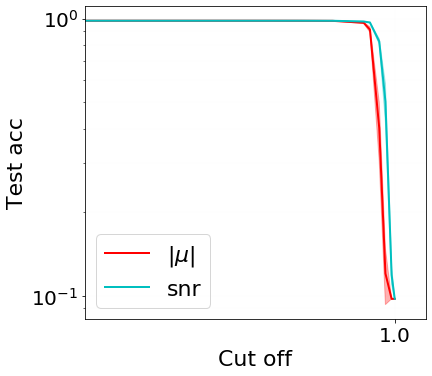

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

_ya_mean = np.mean(ya, axis=0)
_ya_std = np.std(ya, axis=0)
_yb_mean = np.mean(yb, axis=0)
_yb_std = np.std(yb, axis=0)

def test_error(ls):
    return 100*(1-np.array(ls))

fig_size = (6, 5)

set_y_axis = False

lw = 2

grid_color = '0.1'
grid_lw = 0.2

title_size = 16
label_size = 22
tick_size = 20
legend_size = 22

fig, ax = plt.subplots(1, 1, figsize=fig_size)

ax.plot(xs, _ya_mean, linewidth=lw, color='r')
ax.fill_between(xs,
               [x - y for x, y in zip(_ya_mean, _ya_std)],
               [x + y for x, y in zip(_ya_mean, _ya_std)],
               alpha=0.3, color='r')

ax.plot(xs, _yb_mean, linewidth=lw, color='c')
ax.fill_between(xs,
               [x - y for x, y in zip(_yb_mean, _yb_std)],
               [x + y for x, y in zip(_yb_mean, _yb_std)],
               alpha=0.3, color='c')

plt.grid(True, which="both", color=grid_color, linewidth=0.1, alpha=0.1)
ax.set_xlim(0.0, 0.5)
plt.yticks(fontsize=tick_size)
x_ticks = np.arange(0.0, 1.5, step=0.5)
plt.xticks(x_ticks, fontsize=tick_size)
plt.ticklabel_format(axis='y', style='sci')
ax = fig.gca()
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1, 1))
#ax.set_yticklabels([])
plt.yscale('log')
plt.legend(['$|\mu|$', 'snr'], fontsize=legend_size, loc='lower left')
plt.tight_layout()
plt.xlabel("Cut off", fontsize=legend_size)
plt.ylabel("Test acc", fontsize=legend_size)
plt.xlim(0.9, 1.01)
#plt.savefig("plots/weight_pruning_new_hibp_x5.pdf", bbox_inches='tight')
plt.show()

In [21]:
import pickle
with open('weight_pruning_svd_nokl_annealing.pkl', 'wb') as input_file:
    pickle.dump({'xs': xs,
                 'ya': ya,
                 'yb': yb}, input_file)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl

from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 4
rcParams['figure.dpi'] = 200


log_alpha = (model.fc1.log_alpha.cpu().detach().numpy() < 3).astype(np.float)
W = model.fc1.W.cpu().detach().numpy()

# Normalize color map
max_val = np.max(np.abs(log_alpha * W))
norm = mpl.colors.Normalize(vmin=-max_val,vmax=max_val)

plt.imshow(log_alpha * W, cmap='RdBu', interpolation=None, norm=norm)
plt.colorbar()

In [ ]:
s = 0
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 5

z = np.zeros((28*15, 28*15))

for i in range(15):
    for j in range(15):
        s += 1
        z[i*28:(i+1)*28, j*28:(j+1)*28] =  np.abs((log_alpha * W)[s].reshape(28, 28))
        
plt.imshow(z, cmap='hot_r')
plt.colorbar()
plt.axis('off')

In [ ]:
import scipy
import numpy as np
from scipy.sparse import csc_matrix, csc_matrix, coo_matrix, dok_matrix

row, col, data = [], [], []
M = list(model.children())[0].W.data.numpy()
LA = list(model.children())[0].log_alpha.data.numpy()

for i in range(300):
    for j in range(28*28):
        if LA[i, j] < 3:
            row += [i]
            col += [j]
            data += [M[i, j]]

Mcsr = csc_matrix((data, (row, col)), shape=(300, 28*28))
Mcsc = csc_matrix((data, (row, col)), shape=(300, 28*28))
Mcoo = coo_matrix((data, (row, col)), shape=(300, 28*28))

In [ ]:
np.savez_compressed('M_w', M)
scipy.sparse.save_npz('Mcsr_w', Mcsr)
scipy.sparse.save_npz('Mcsc_w', Mcsc)
scipy.sparse.save_npz('Mcoo_w', Mcoo)